In [84]:
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [85]:
def add_features(df):
    df['month'] = df['PRICES'].dt.month - 1
    df['day'] = df['PRICES'].dt.day - 1
    df['year'] = df['PRICES'].dt.year
    df['day_of_week'] = df['PRICES'].dt.dayofweek
    df['day_of_week'] = df['day_of_week'].astype(int)
    df = df.drop(columns=["PRICES"])
    return df

train = pd.read_excel("train.xlsx", parse_dates=['PRICES'])
val = pd.read_excel("validate.xlsx", parse_dates=['PRICES'])
train = add_features(train)
val = add_features(val)
train.head()

,Hour 01,Hour 02,Hour 03,Hour 04,Hour 05,Hour 06,Hour 07,Hour 08,Hour 09,Hour 10,...,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24,month,day,year,day_of_week
0,24.31,24.31,21.71,8.42,0.01,0.01,0.02,0.01,0.01,6.31,...,37.99,33.11,37.99,33.00,36.48,30.65,0,0,2007,0
1,16.01,11.00,9.01,7.50,9.00,7.45,16.50,28.01,29.96,39.60,...,59.69,50.09,50.00,36.22,31.09,29.84,0,1,2007,1
2,28.00,24.50,24.15,18.99,15.50,23.11,29.01,39.73,43.81,49.09,...,60.99,55.51,51.77,34.51,39.31,38.05,0,2,2007,2
3,31.01,28.69,27.00,24.20,12.02,27.00,28.00,34.85,41.31,42.03,...,58.99,53.50,44.01,35.00,34.46,31.57,0,3,2007,3
4,22.00,19.50,17.55,15.91,11.40,22.65,27.30,34.00,40.01,45.00,...,53.00,45.91,36.74,29.61,30.61,27.51,0,4,2007,4


In [86]:
class SmartGridEnv(gym.Env):
    def __init__(self, price_data, battery_capacity=50, max_power=25, efficiency=0.9):
        super(SmartGridEnv, self).__init__()
        self.price_data = price_data
        self.battery_capacity = battery_capacity
        self.max_power = max_power
        self.efficiency = efficiency
        self.action_space = gym.spaces.Discrete(51, start=-25) 
        self.time_constraint = 6
        self.battery_time_constraint = 20
        self.initialize_params()

    def initialize_params(self):
        self.current_step = 0
        self.current_month = 0
        self.current_day = 0
        self.current_hour = 0
        self.day_of_week = int(self.price_data.iloc[self.current_step]['day_of_week'])
        self.current_price = self.price_data.iloc[self.current_step, self.current_hour]
        self.current_battery = 20
        self.available = True
        self.current_state = np.array([self.current_hour, self.current_battery, self.current_price])
        self.done = False
        self.profit = 0

    def car_available(self):
        if self.current_hour == 7:
            available = np.random.uniform(0, 1) < 0.5
        else:
            available = True
        return available 
        
    def to_discrete(self, action):
        mask = np.zeros(self.action_space.n, dtype=np.int8)
        mask[action] = 1
        return self.action_space.sample(mask = mask)

    def reward(self, action, charge_cost):
        return -charge_cost
        
    def step(self, action):
        self.available=self.car_available()
        if not self.available:
            self.current_hour = 17
            self.current_battery -= 20
            charge_cost = 0
        else:
            # discretize action
            action = self.to_discrete(action) 
            
            # update hour & step
            self.current_hour = int((self.current_hour + 1) % 24)
            if self.current_hour == 0:
                self.current_step += 1
        
            # update battery
            self.current_price = self.price_data.iloc[self.current_step, self.current_hour]
            charge_cost = action if action < 0 else action* 2 
            charge_cost *= self.current_price / 1000
            actual_charge = np.round(self.efficiency * action).astype(int) if action>0 else np.round(action/self.efficiency).astype(int)
            self.current_battery += actual_charge
            
            self.current_month = int(self.price_data.iloc[self.current_step]['month'])
            self.current_day = int(self.price_data.iloc[self.current_step]['day'])
            self.day_of_week = int(self.price_data.iloc[self.current_step]['day_of_week'])

        # rewards
        self.profit += -charge_cost
        reward = self.reward(action, charge_cost)

        # state
        self.current_state = np.array([self.current_hour, self.current_battery, self.current_price])   

        # Chec if done
        if self.current_step >= len(self.price_data) - 1:
            self.done = True
        
        return self.current_state, reward, self.done, self.available

In [87]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state, mask):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = self.actor_linear2(policy_dist)
        policy_dist = torch.where(mask, policy_dist, torch.finfo(torch.float).min) #masking
        policy_dist = F.softmax(policy_dist, dim=1)

        return value, policy_dist

def create_mask(env):
    # 7 am constraint  
    if env.current_hour == env.time_constraint and env.current_battery >= env.battery_time_constraint:
        lower_bound = min(np.ceil((env.battery_time_constraint- env.current_battery)*0.9), env.max_power)
        upper_bound =  min(np.floor((env.battery_capacity-env.current_battery)/0.9), env.max_power)
        mask_range = (lower_bound, upper_bound)
    elif env.current_hour == env.time_constraint and env.current_battery < env.battery_time_constraint:
        lower_bound = min(np.ceil((env.battery_time_constraint-env.current_battery)/0.9), env.max_power)
        upper_bound =  min(np.floor((env.battery_capacity-env.current_battery)/0.9), env.max_power)
        mask_range = (lower_bound, upper_bound)
    else: 
        lower_bound = max(np.ceil(-(env.current_battery)*0.9), -env.max_power)
        upper_bound = min(np.floor((env.battery_capacity - env.current_battery)/0.9), env.max_power)
        mask_range = (lower_bound, upper_bound)
    
    # construct boolean mask_vector
    mask = np.arange(env.action_space.start, env.action_space.start + env.action_space.n)
    mask = np.where((mask >= mask_range[0]) & (mask <= mask_range[1]), True, False) 
    return torch.tensor(mask)

def normalize_features(state):
    term = np.array([1/25, 1/51, 1/1000])
    state = state * term + term
    return state 

## Train

episode: 0, reward: -3.40784 

episode: 365, reward: 0.32321 

episode: 730, reward: -0.83521 

episode: 1095, reward: 0.32574 

episode: 1460, reward: 0.4352 

episode: 1825, reward: 0.4352 

episode: 2190, reward: 0.4352 

episode: 2555, reward: -0.83521 

episode: 2920, reward: 0.4352 

episode: 3285, reward: 0.4352 

episode: 3650, reward: -0.83521 

episode: 4015, reward: 0.4352 

episode: 4380, reward: -0.10003000000000006 

episode: 4745, reward: -0.10003000000000006 

episode: 5110, reward: -0.6671900000000002 

episode: 5475, reward: 0.43516 

episode: 5840, reward: -0.6671900000000002 

episode: 6205, reward: 0.305 

episode: 6570, reward: -0.10005000000000008 

episode: 6935, reward: -0.6672100000000001 

episode: 7300, reward: -0.6672100000000001 

episode: 7665, reward: 0.43513999999999997 



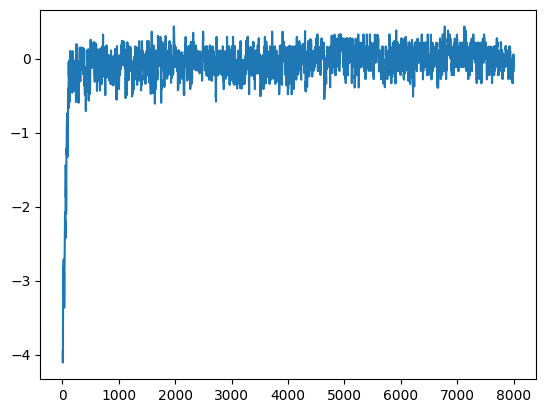

In [91]:
env = SmartGridEnv(train)
num_inputs = len(env.current_state)
num_outputs = env.action_space.n
num_episodes = 8000
num_steps = 24
hidden_size = 64
learning_rate = 1e-2
discount = 0.99

actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

all_rewards = []
entropy_term = 0

for episode in range(num_episodes):
    log_probs = []
    values = []
    rewards = []
    env.initialize_params()
    state = env.current_state
    
    for step in range(num_steps):
        state = normalize_features(state)
        mask = create_mask(env)
        value, policy_dist = actor_critic.forward(state, mask)
        value = value.detach().numpy()[0,0]
        dist = policy_dist.detach().numpy()

        action = np.random.choice(num_outputs, p=np.squeeze(dist))
        log_prob = torch.log(policy_dist.squeeze(0)[action])
        entropy = -np.sum(np.mean(dist[0, mask]) * np.log(dist[0,mask]))
        new_state, reward, done, _ = env.step(action)

        # bookkeeping
        rewards.append(reward)
        values.append(value)
        log_probs.append(log_prob)
        entropy_term += entropy
        state = new_state

        if done or step == num_steps - 1:
            mask = create_mask(env)
            Qval, _ = actor_critic.forward(new_state, mask)
            Qval = Qval.detach().numpy()[0,0]
            all_rewards.append(np.sum(rewards))
            if episode % 365 == 0:                    
                print("episode: {}, reward: {} \n".format(episode, np.sum(rewards),))
            break

    # compute Q values
    Qvals = np.zeros_like(values)
    for t in reversed(range(len(rewards))):
        Qval = rewards[t] + discount * Qval
        Qvals[t] = Qval

    #update actor critic
    values = torch.FloatTensor(values)
    Qvals = torch.FloatTensor(Qvals)
    log_probs = torch.stack(log_probs)
    
    advantage = Qvals - values
    actor_loss = (-log_probs * advantage).mean()
    critic_loss = 0.5 * advantage.pow(2).mean()
    ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

    ac_optimizer.zero_grad()
    ac_loss.backward()
    ac_optimizer.step()


smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.plot(smoothed_rewards)
plt.show()

In [92]:
eval_env = SmartGridEnv(val)
current_state = eval_env.current_state

while not eval_env.done:
    mask = create_mask(eval_env)
    current_state = normalize_features(current_state)

    value, policy_dist = actor_critic.forward(current_state, mask)
    value = value.detach().numpy()[0,0]
    dist = policy_dist.detach().numpy()
    
    action = np.random.choice(num_outputs, p=np.squeeze(dist))
    new_state, reward, done, _ = eval_env.step(action)
    current_state = new_state
    
    print(f"at time {eval_env.current_hour +  1} agent transacts {eval_env.to_discrete(action)} KWh, battery is {eval_env.current_battery}")

print("Profit on validation set: ", eval_env.profit)

at time 2 agent transacts -11 KWh, battery is 8
at time 3 agent transacts -6 KWh, battery is 1
at time 4 agent transacts 0 KWh, battery is 1
at time 5 agent transacts 0 KWh, battery is 1
at time 6 agent transacts 0 KWh, battery is 1
at time 7 agent transacts 0 KWh, battery is 1
at time 8 agent transacts 25 KWh, battery is 23
at time 9 agent transacts -11 KWh, battery is 11
at time 10 agent transacts -6 KWh, battery is 4
at time 11 agent transacts 0 KWh, battery is 4
at time 12 agent transacts 0 KWh, battery is 4
at time 13 agent transacts 0 KWh, battery is 4
at time 14 agent transacts 0 KWh, battery is 4
at time 15 agent transacts 0 KWh, battery is 4
at time 16 agent transacts 0 KWh, battery is 4
at time 17 agent transacts 0 KWh, battery is 4
at time 18 agent transacts 0 KWh, battery is 4
at time 19 agent transacts 0 KWh, battery is 4
at time 20 agent transacts 0 KWh, battery is 4
at time 21 agent transacts 0 KWh, battery is 4
at time 22 agent transacts 0 KWh, battery is 4
at time 23 a